# High performance calculation of heatmaps using CAS 

### Import Libraries

In [12]:
import matplotlib.pyplot as plt
import time

from swat import *

## Connect to a Server

In [3]:
s = CAS('cas01', 10338)

In [4]:
s.loadactionset(actionset='image')
s.loadactionset(actionset='fedsql')
s.loadactionset(actionset='transpose')

image_path = "/net/narndnas02.unx.sas.com/vol/vol2/fvcc/PhotoData/cvExplain/aicoe/FOR_CAS_HEATMAPS/"
caslib_name = "dlib"
response = s.table.addCaslib(
        name=caslib_name,
        session=True,
        dataSource={"srctype": "path"},
        path=image_path,
        subDirs=True
    )

NOTE: Added action set 'image'.
NOTE: Added action set 'fedsql'.
NOTE: Added action set 'transpose'.
NOTE: 'dlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'dlib'.


# Heatmap Generation Pipeline

## Load Tracking Data and Base Image

In [6]:
csv_path = 'trackdata/57_2019-10-08_obj_tracks.csv'

In [7]:
tracking_data = s.CASTable('tracking_data', replace=True)
response = s.table.loadTable(
    path=csv_path,
    casout=tracking_data
)

NOTE: Cloud Analytic Services made the file trackdata/57_2019-10-08_obj_tracks.csv available as table TRACKING_DATA in caslib dlib.


In [8]:
base_image_patch = 'base_img.jpg'

In [9]:
base_image = s.CASTable('base_image', replace=True)
response = s.image.loadimages(
    path=base_image_patch,
    casout=base_image,
)    

NOTE: Loaded 1 image from /net/narndnas02.unx.sas.com/vol/vol2/fvcc/PhotoData/cvExplain/aicoe/FOR_CAS_HEATMAPS/base_img.jpg into Cloud Analytic Services table base_image.


## Pre-Process
1. Calculate centroids from the top-left and bottom-right bounding box coordinates.
1. Filter out any centroids that leave the image boundary.
1. Parse the frame number from the filename and then calculate the time window ID based on the frame number, framerate, and window length (in minutes).

In [10]:
# Get the base image width and height.
image = base_image.fetchImages().Images
width, height = (image.Width[0], image.Height[0])

# Parameters known a priori.
framerate = 10

# Parameters that are manually set by user.
heatmap_resolution = 13
heatmap_window_minutes = 5

preprocessed_data = s.CASTable('preprocessed_data', replace=True)
response = s.datastep.runcode(
    code=f'''data preprocessed_data;
                set tracking_data;

                /* Calculate centroids from the top-left and bottom-right bounding box coordinates. */
                cx = BRx/2 + TLx/2;
                cy = BRy/2 + TLy/2;
                
                /* Filter out any centroids that leave the image boundary. */
                if cx >= 0 and cx < {width} and cy >= 0 and cy < {height} then do;
                
                    /* Parse the frame number from the filename and then calculate the time window ID based on
                       the frame number, framerate, and window length (in minutes). */
                    time_window_id = floor((int(scan(filename,-2,'_./'))-1) / {heatmap_window_minutes*60*framerate});
                    
                    output; 
                end;

             run;
''')

NOTE: The table BASE_IMAGE contains encoded images.
NOTE: Varchar values have been converted to numeric values at the places given by: (Line):(Column).
      2:159


## Calculate 2D-Histogram

In [11]:
total_num_bins = heatmap_resolution*heatmap_resolution
pixels_per_bin = width/heatmap_resolution

histograms = s.CASTable('histograms', replace=True)
response = s.datastep.runcode(
    code=f'''data histograms (keep=c01-c{total_num_bins} time_window_id);
                 set preprocessed_data;
            
                 /* Process by time_window_id to get one histogram per time interval.*/
                 by time_window_id;

                 /* Create histogram bins and instruct DATAstep to retain values between rows.*/
                 array histogram_bins{{{heatmap_resolution},{heatmap_resolution}}} c01-c{total_num_bins};
                 retain histogram_bins;

                 /* 'Bin' the centroid coordinates.*/
                 x = floor(cx/{pixels_per_bin})+1;
                 y = floor(cy/{pixels_per_bin})+1;
            
                 /* Increment the histogram bin values based on the binned coordinates.*/
                 if histogram_bins{{y,x}}=. then histogram_bins{{y,x}}=1;
                 else histogram_bins{{y,x}}=histogram_bins{{y,x}}+1;

                 /* When all observations in a time window are processed, write the result to the output table.*/
                 if last.time_window_id then output;
             run;
''')

## Post-Process
1. Condense the wide table into an image column
1. Normalize the histogram bins and scale to unsigned 8 bit integer
1. Resize to fit base image width / height

In [25]:
# Transform the wide table into a single '_image_' column.
heatmaps = s.CASTable('heatmaps', replace=True)
response = s.image.condenseimages(
    table=histograms,
    casout=heatmaps,
    width=heatmap_resolution,
    height=heatmap_resolution,
    numberofchannels='GRAY_SCALE_IMAGE',
    depth='bit64',
    decode=True,
    copyVars=['time_window_id']
)

# Normalize/rescale the histogram bins to an unsigned 8 bit integer range and then resize to the base image width/height.
post_processed_images = s.CASTable("post_processed_images", replace=True)
response = s.image.processimages(
    table=heatmaps,
    casout=post_processed_images,
    steps=[
        dict(step=dict(steptype='normalize', alpha=0, beta=255.0, type='minmax')),
        dict(step=dict(steptype='rescale', type='to_8u')),
        dict(step=dict(functionType="RESIZE", width=width, height=height)),
    ],
    decode=False, 
    copyVars=['time_window_id']
)

NOTE: 22 out of 22 images were processed successfully and saved to the Cloud Analytic Services table heatmaps.
NOTE: The table HEATMAPS contains decoded images.
NOTE: 22 of 22 images were processed successfully and saved as encoded images to the Cloud Analytic Services table post_processed_images.


## Overlay the Heatmap on Base Image
1. Join the base image to each generated heatmap
1. Use annotateImages to create color map

In [27]:
# Join each heatmap we generated to the base image.
join_table = s.CASTable('join_table', replace=True)
response = s.fedsql.execdirect('''
    create table join_table {options replace=true} as (
    select
      a._image_, a._size_, a._path_, a._type_,
      b._image_ as _image2_, b.time_window_id as _id_
    from base_image as a, post_processed_images as b
    ) 
''')

# Overlay the heatmaps on the base image.
annotated_images = s.CASTable('annotated_images', replace=True)
response = s.image.annotateimages(
    images='join_table',
    annotations=[
        dict(annotation=dict(annotationtype='segmentation', image='_image2_', ))
    ],
    casout=annotated_images,
    copyVars=['time_window_id','_id_']
)

NOTE: Table JOIN_TABLE was created in caslib dlib with 22 rows returned.
NOTE: 22 of 22 images were processed successfully and saved as encoded images to the Cloud Analytic Services table annotated_images.


# Performance Analysis

In [20]:
plt.rcParams['figure.figsize'] = [10, 10]

In [21]:
min_bins = [1,2,5,10,15,20] # 13 heatmap bins
notebook = [31.2728157043457,30.176329016685486,29.99776804447174,29.153503596782684,30.894105553627014,30.87476086616516]
data_step_smp = [6.711381673812866,5.978211879730225,5.191610813140869,5.061034917831421,4.928530931472778,4.949522495269775]
data_step_mpp = [3.46529221534729,3.1238338947296143,3.0145115852355957,2.989863872528076,2.774949312210083,2.97733736038208]

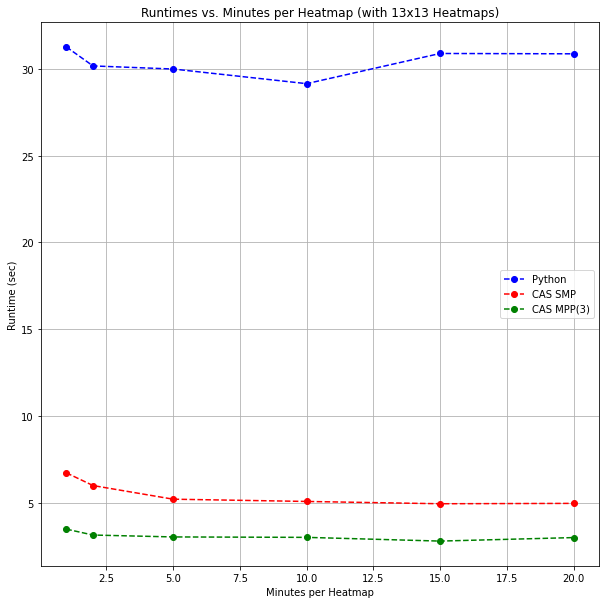

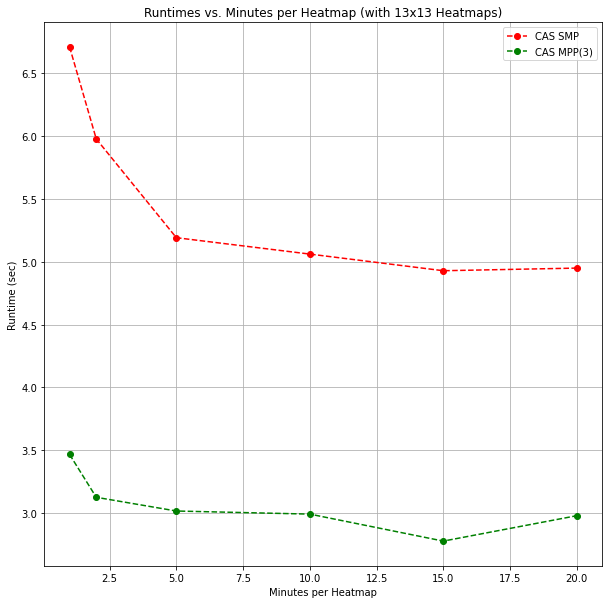

In [22]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(min_bins, notebook, label='Python', color='b', linestyle='--', marker='o') 
ax.plot(min_bins, data_step_smp, label='CAS SMP', color='r', linestyle='--', marker='o') 
ax.plot(min_bins, data_step_mpp, label='CAS MPP(3)', color='g', linestyle='--', marker='o') 
ax.grid()

ax.set_xlabel('Minutes per Heatmap')  
ax.set_ylabel('Runtime (sec)')  
ax.set_title('Runtimes vs. Minutes per Heatmap (with 13x13 Heatmaps)')
ax.legend()


fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(min_bins, data_step_smp, label='CAS SMP', color='r', linestyle='--', marker='o') 
ax.plot(min_bins, data_step_mpp, label='CAS MPP(3)', color='g', linestyle='--', marker='o') 
ax.grid()

ax.set_xlabel('Minutes per Heatmap')  
ax.set_ylabel('Runtime (sec)')  
ax.set_title('Runtimes vs. Minutes per Heatmap (with 13x13 Heatmaps)')
ax.legend()

In [23]:
resolutions = [8,13,16,26,32,64,128] # 5 minutes bins
notebook = [29.908584356307983,30.02068462371826,29.88791584968567,31.036171197891235,28.652110815048218,29.175268793106078,28.52751421928406]
data_step_smp = [5.129576683044434,5.23438663482666,5.191610813140869,5.320265054702759,5.442054510116577,5.687150955200195,6.842198133468628]
data_step_mpp = [3.0188982486724854,3.0145115852355957,3.108753204345703,3.065168619155884,3.0326390266418457,3.2563681602478027,4.186103820800781]

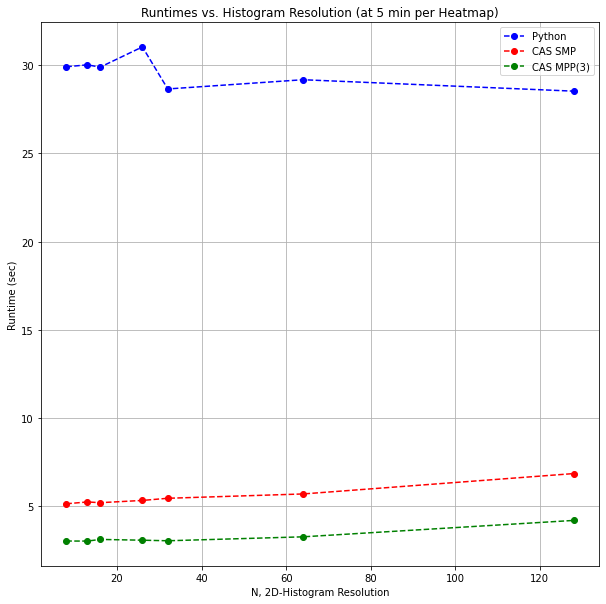

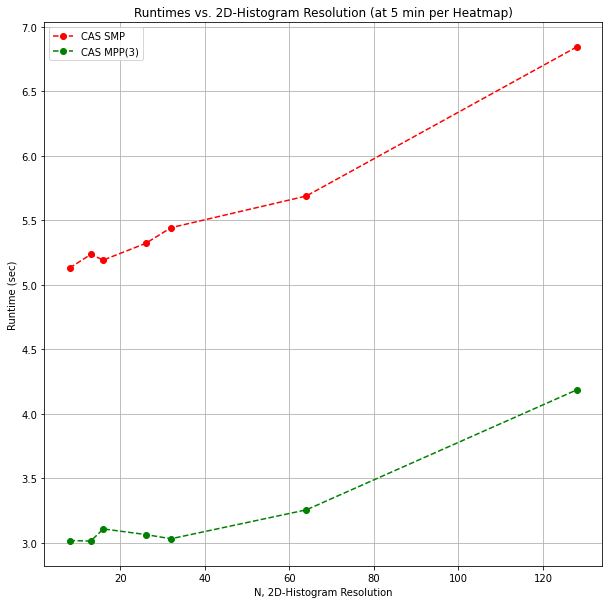

In [24]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(resolutions, notebook, label='Python', color='b', linestyle='--', marker='o') 
ax.plot(resolutions, data_step_smp, label='CAS SMP', color='r', linestyle='--', marker='o') 
ax.plot(resolutions, data_step_mpp, label='CAS MPP(3)', color='g', linestyle='--', marker='o') 
ax.grid()

ax.set_xlabel('N, 2D-Histogram Resolution')  
ax.set_ylabel('Runtime (sec)')  
ax.set_title("Runtimes vs. Histogram Resolution (at 5 min per Heatmap)")  
ax.legend()


fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(resolutions, data_step_smp, label='CAS SMP', color='r', linestyle='--', marker='o')  
ax.plot(resolutions, data_step_mpp, label='CAS MPP(3)', color='g', linestyle='--', marker='o') 
ax.grid()

ax.set_xlabel('N, 2D-Histogram Resolution')  
ax.set_ylabel('Runtime (sec)')  
ax.set_title("Runtimes vs. 2D-Histogram Resolution (at 5 min per Heatmap)")
ax.legend()